In [1]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx, CoolProp
import Calculus
import GR
FF = FractionalFlow

FractionalFlow


Use "const UInt8 = Uint8" instead.

Use "const Ref = Ptr" instead.

Use "const AbstractString = String" instead.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{UInt8}, ::Int64) at ./deprecated.jl:57
 [3] include_from_node1(::String) at ./loading.jl:576
 [4] include(::String) at ./sysimg.jl:14
 [5] include_from_node1(::String) at ./loading.jl:576
 [6] eval(::Module, ::Any) at ./boot.jl:235
 [7] _require(::Symbol) at ./loading.jl:490
 [8] require(::Symbol) at ./loading.jl:405
 [9] include_string(::String, ::String) at ./loading.jl:522
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ali/.julia/v0.6/IJulia/src/execute_request.jl:180
 [11] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/ali/.julia/v0.6/Compat/src/Compat.jl:332
 [12] eventloop(::ZMQ.Socket) at /home/ali/.julia/v0.6/IJulia/src/eventloop.jl:8
 [13] (::IJulia.##15#18)() at ./task.jl:335
while loading /home/ali/.julia/v0.6/CoolPr

## Experimental data

In [2]:
L_core = 0.104
D_core = 0.025
poros  = 0.256
A_core  = π*D_core^2/4
V_core = A_core*L_core
PV_core = L_core*A_core*poros

swinit     = 0.334 # 0.334
swi = (1-swinit)*0.610+swinit
soi     = 1-swi
T_c     = 55.6
mu_oil = 0.000402 # 1.04e-3*1.15 # *1.15 for temperature effect (70 -> 55)
T_K = T_c + 273.15
perm_ave = 0.001e-12 # m^2 permeability
p0 = 2000/14.7*1e5
mu_water = 0.00116 # PropsSI("viscosity", "T", T_K, "P", p0, "H2O")
pv_inj_R_exp = [9.129, 9.969, 10.204, 10.574, 11.406, 12.499, 14.110, 15.471, 16.834, 17.612]-9.129
R_oil_exp = [0.610, 0.693, 0.769, 0.828, 0.866, 0.900, 0.938, 0.945, 0.948, 0.952]-0.610
R_oil_exp_int = Spline1D(pv_inj_R_exp, R_oil_exp, k=1)
pv_inj_dp = [9.129, 9.194, 9.194, 9.194, 9.323, 9.516, 9.645, 9.710,
9.839, 9.903, 10.290, 10.290, 10.290, 10.484, 10.548, 10.548, 10.548, 11.065,
12.032, 12.742, 13.774, 14.226, 14.484, 15.387, 16.355, 17.323]-9.129
dp_exp = [0.095, 0.150, 0.205,
0.257, 0.309, 0.357, 0.412, 0.464, 0.516, 0.571, 0.622, 0.571, 0.516, 0.447, 0.495, 0.512,
0.571, 0.612, 0.626, 0.657, 0.643, 0.698, 0.647, 0.664, 0.657, 0.657]*20*1e5

# estimate the injection rate
# a, b = linreg(pv_inj_R_exp[1:4], R_oil_exp[1:4])
# u_est = b*(1-swi)*poros*V_core/A_core
# u_est =  dp_exp[1]/L_core*perm_ave/(mu_oil*1.5)
# u_est = 73200/L_core*perm_ave/mu_water*0.8 # multiplie by an estimated relperm
u_est = 9/(74*3600)*13.38e-6/A_core # estimated by comparing two figures from different papers
# the injection velocity seems to be 1 ft/day real velocity (not Darcy)

pv_inj_exp = pv_inj_dp[:] # same as the time steps for the dp
R_oil = R_oil_exp_int(pv_inj_exp) # just to have both dp and R for the same time steps

pv_inj = pv_inj_exp[end]
# injection_rate = 0.00011/(3600*24) # 
injection_rate = u_est*A_core # 0.001/(3600*24) # m^3/day
recovery_final = R_oil_exp[end]

so_final = (1-recovery_final)*soi # final oil saturation

t_sec = pv_inj_exp*PV_core/injection_rate

# conversion of the input data to the right unit
u_inj   = injection_rate/A_core # Darcy velocity



9.208618977598095e-7

# Water-flooding

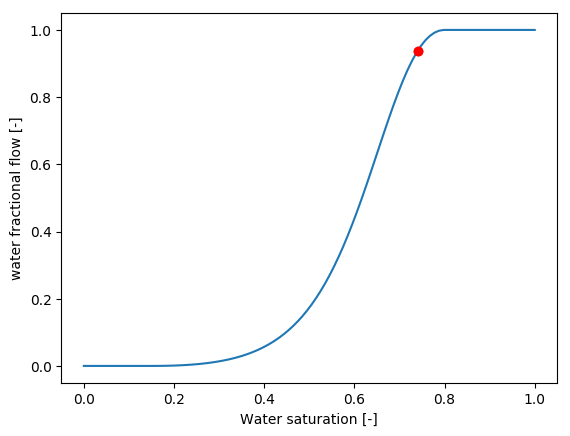

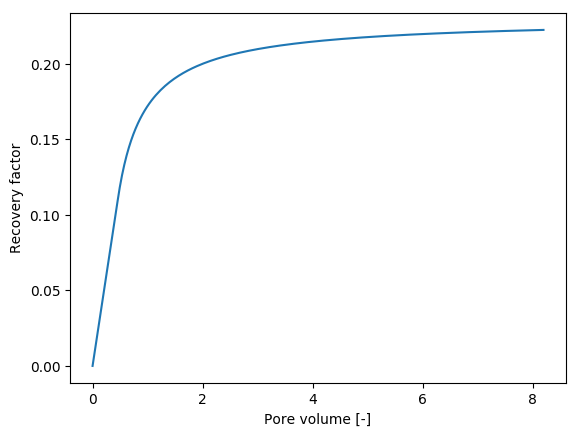

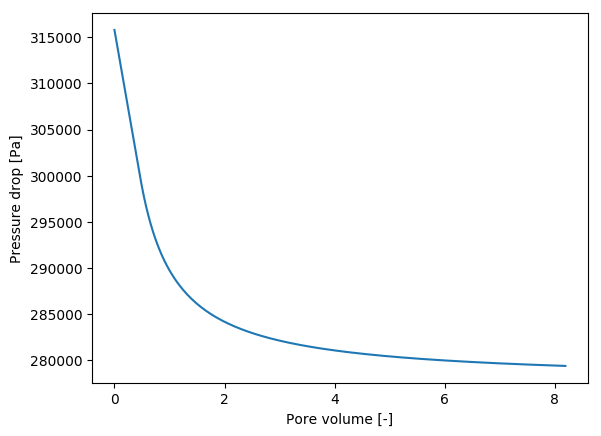

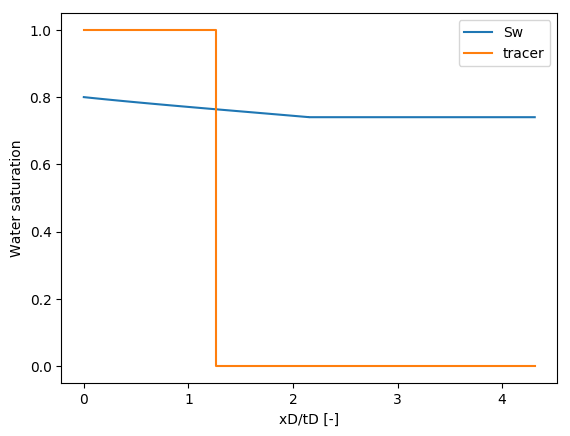

PyObject <matplotlib.legend.Legend object at 0x7f9584f4b210>

In [3]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=mu_water, mu_oil=mu_oil)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
core_flood = FF.core_flooding(u_inj=u_inj, pv_inject=pv_inj, 
    p_back=p0, sw_init=swi, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties(L=L_core, D=D_core, φ=poros, k=perm_ave)
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)

FF.visualize(wf_res)

In [4]:
# t_sec, pv, rec_fact, dp_core, x, sw, c, c_out_sal=
#             FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood)

In [5]:
# figure()
# plot(t_sec, rec_fact, "o", wf_res.recovery_time[:,1], wf_res.recovery_time[:,2])
# figure()
# plot(t_sec, dp_core, "o", wf_res.dp_time[:,1], wf_res.dp_time[:,2])

# Experimental data


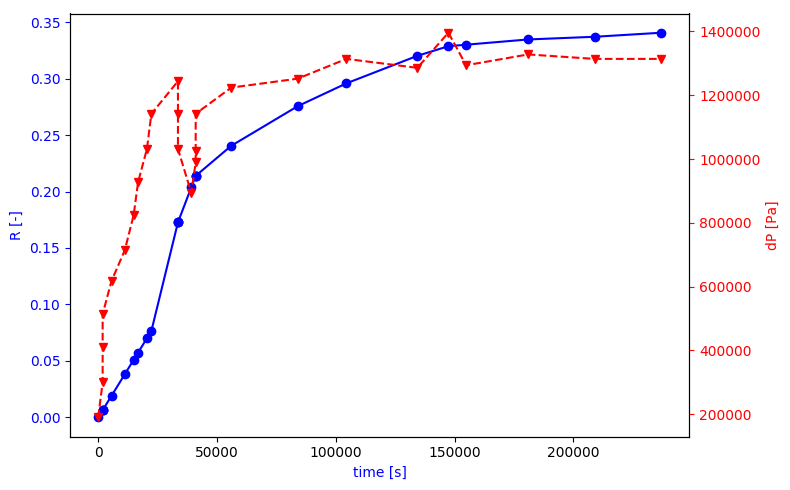

(PyPlot.Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f9584e528d0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f9584df7cd0>)

In [4]:
t_exp_dp = t_sec[:]
# dp_exp 
t_exp_R = t_sec[:]
R_exp = R_oil[:]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

# define the objective function

In [5]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp)

exp_data([0.0, 1879.28, 1879.28, 1879.28, 5608.94, 11189.0, 14918.6, 16797.9, 20527.6, 22377.9  …  41026.2, 55973.7, 83931.7, 1.04459e5, 1.34296e5, 1.47365e5, 154824.0, 1.80932e5, 2.08918e5, 2.36905e5], [190000.0, 300000.0, 410000.0, 514000.0, 618000.0, 714000.0, 824000.0, 928000.0, 1.032e6, 1.142e6  …  1.142e6, 1.224e6, 1.252e6, 1.314e6, 1.286e6, 1.396e6, 1.294e6, 1.328e6, 1.314e6, 1.314e6], [0.0, 1879.28, 1879.28, 1879.28, 5608.94, 11189.0, 14918.6, 16797.9, 20527.6, 22377.9  …  41026.2, 55973.7, 83931.7, 1.04459e5, 1.34296e5, 1.47365e5, 154824.0, 1.80932e5, 2.08918e5, 2.36905e5], [0.0, 0.00642262, 0.00642262, 0.00642262, 0.019169, 0.0382393, 0.0509857, 0.0574083, 0.0701548, 0.0764786  …  0.213854, 0.240425, 0.275473, 0.295732, 0.320074, 0.328597, 0.329924, 0.334568, 0.336946, 0.340514])

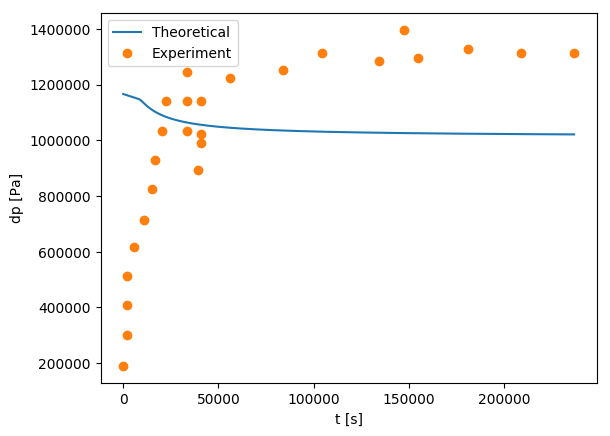

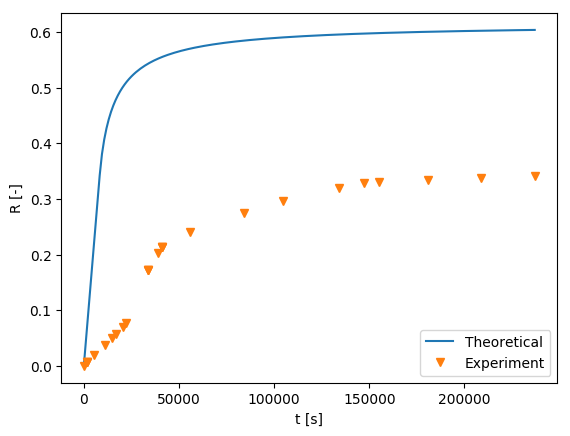

4.543724050889616

In [7]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R./(exp_data.R_exp+eps())
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 2, 2.0, 0.19, 0.1]

vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# define the objective function and gradients and weight factors

In [12]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
ind_max = indmax(exp_data1.dp_exp)
w_p[ind_max-1:ind_max+2] = 10
w_p[end:end-5]=10
w_p[1]=1
w_R = ones(length(exp_data1.R_exp))
# w_R[20:25] = 10
w_R[end:end-5]=10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.2])

2.457838948479299

In [9]:
grad_x

6-element Array{Float64,1}:
  0.640028 
 -0.0108829
 -0.066574 
  0.0198171
 -0.409011 
  3.9472   

In [11]:
## algorithms
# L: Local, G:global
# D: derivative-based, N: non-derivative (search-based)

# :LD_MMA
# :LN_COBYLA
# :LD_LBFGS
# :GN_DIRECT
# :GN_DIRECT_L
# GN_CRS2_LM
# G_MLSL_LDS
# GD_STOGO
# GN_ISRES
# GN_ESCH
# LN_NEWUOA_BOUND
# LN_BOBYQA
# LN_PRAXIS
# LN_NELDERMEAD
# LN_SBPLX
# LD_SLSQP
# LD_TNEWTON_PRECOND_RESTART
# LD_TNEWTON_RESTART
# LD_TNEWTON_PRECOND


In [15]:
x_init = [0.227374, 0.268374, 3.75437, 3.82896, 0.241672, 0.160291]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.03]
x_ub = [1.0, 1.0, 4.0, 4.0, 0.3, 0.25]
opt_alg=:LD_SLSQP
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-15)
ftol_abs!(opt1, 1e-15)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

(1.0387473683185253, [0.100673, 0.975192, 1.50001, 3.60052, 0.0500001, 0.151218], :FTOL_REACHED)

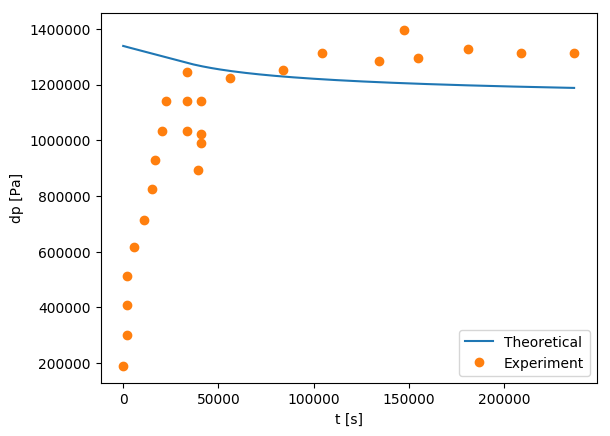

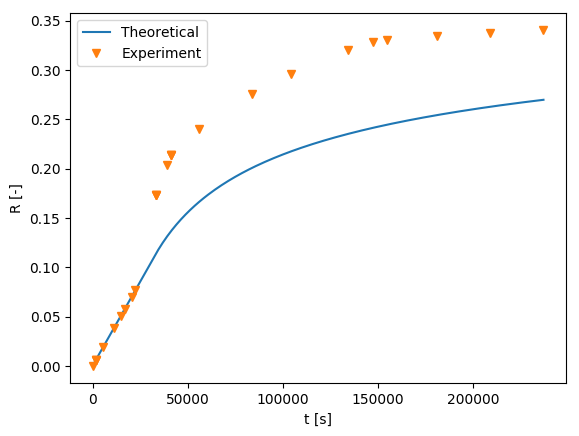

0.9119187393719549

In [16]:
x_init = paramOpt
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

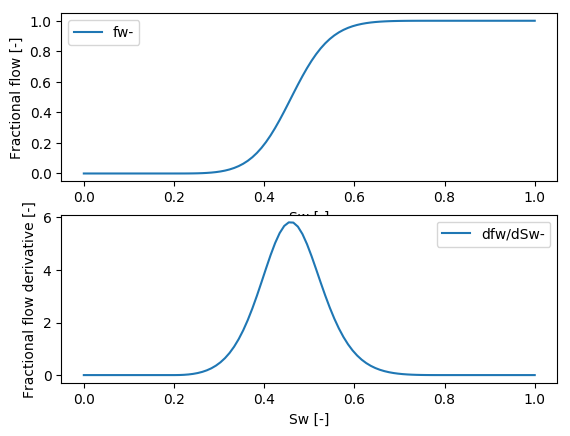

PyObject <matplotlib.legend.Legend object at 0x7f15558edb50>

In [38]:
rel_perm_param=[1.0, 0.8, 3, 4, 0.2, 0.2]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2, fluids)